In [18]:
from statistics import mean, median
from requests import get
import matplotlib.pyplot as plt
import numpy as np


plt.rcParams['axes.linewidth'] = 0.8
plt.style.use('seaborn-colorblind')
metric = 'ndcg'
cutoff = 10
n_questions = 10
de_only = True
experiment_subset = 'equal'

cm = plt.get_cmap('tab20b') 
n_lines = len(baselines) + len(unique_models)
cm = [cm(1. * i / n_lines) for i in range(n_lines)]

data = get(f'https://mindreader.tech/spectate/results/{experiment_subset}/{metric}/{cutoff}').json()
data = {k: v for k, v in data.items() if not 'grid' in k}

metric = metric.replace('cov', 'div') if metric == 'cov' else metric  # Hack job :-)
interviewer_kinds = ['greedy-adaptive-', 'greedy-', 'pop-'] #, 'dqn-', 'ddpg-']

def replace_all(string, lst):
    for item in lst:
        string = string.replace(item, '')
    
    return string

unique_models = set([replace_all(model, interviewer_kinds) for model in data.keys()])
if de_only:
    unique_models = set([model.replace('-rec', '') for model in unique_models])
else:
    unique_models = set([model for model in unique_models if model.endswith('-rec')])

print(unique_models)
unique_models = sorted(set([model for model in unique_models if all([f'{interviewer}{model}' in data for interviewer in interviewer_kinds])]))
print(unique_models)

baselines = ['fmf', 'lrmf', 'melu']


{'mf', 'melu', 'dqn-ppr-joint', 'fmf', 'top-pop', 'ppr-linear-learned', 'lrmf', 'dqn-mf', 'linear-fc-learned', 'random', 'dqn-knn', 'knn', 'ppr-collab', 'ppr-joint', 'ppr-kg', 'ppr-linear-joint-learned'}
['knn', 'mf', 'ppr-collab', 'ppr-joint', 'ppr-kg', 'ppr-linear-learned']


mean: 3.45
median: 3.0


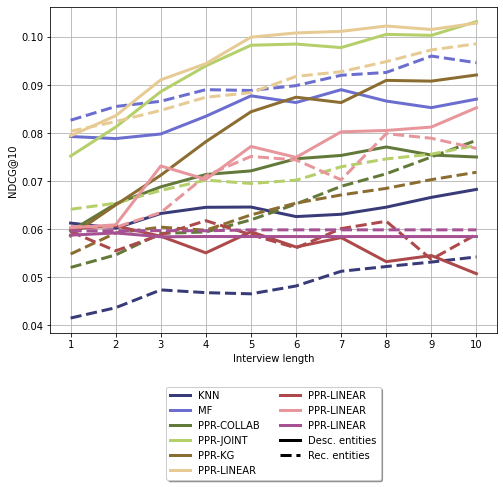

In [22]:
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind, ttest_rel
from matplotlib.lines import Line2D


fig_width = 8  # Increase if bars become to small to see 
fig_height = 6
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

interviewer = 'greedy-adaptive'
interview_length = 10

model_label_map = {
    'knn': 'KNN', 'mf': 'MF', 'ppr-collab': 'PPR-COLLAB', 
    'ppr-joint': 'PPR-JOINT', 'ppr-kg': 'PPR-KG', 
    'ppr-linear-learned': 'PPR-LINEAR'
}

interviewer_label_map = {
    'greedy': 'FG',
    'greedy-adaptive': 'AG',
    'pop': 'FP'
}

xs = np.arange(interview_length) + 1
handles = []
diff = []
for i, model in enumerate(unique_models): 
    model_key = f'{interviewer}-{model}'
    model_key_rec = f'{model_key}-rec'
    
    ys_de = [np.mean(data[model_key][q]) for q in range(interview_length)]
    ys_re = [np.mean(data[model_key_rec][q]) for q in range(interview_length)]
    for k in range(interview_length):
        de_val = ys_de[k]
        s = set()
        for j in range(k, interview_length):
            re_val = ys_re[j]
            if re_val < de_val:
                s.add(j)

        diff.append(len(s))
    
    h_de, = plt.plot(xs, ys_de, label=model_label_map[model], linewidth=3, color=cm[i])
    h_re, = plt.plot(xs, ys_re, linewidth=3, linestyle='--', color=cm[i])
    
    handles.append(h_de)
    
    
for baseline in baselines: 
    i += 1
    b = f'{baseline}'
    b_rec = f'{baseline}-rec'
    
    ys_de = [np.mean(data[b][q]) for q in range(interview_length)]
    ys_re = [np.mean(data[b_rec][q]) for q in range(interview_length)]
    
    for k in range(interview_length):
        de_val = ys_de[k]
        s = set()
        for j in range(k, interview_length):
            re_val = ys_re[j]
            if re_val < de_val:
                s.add(j)
                
    h_de, = plt.plot(xs, ys_de, label=model_label_map[model], linewidth=3, color=cm[i])
    h_re, = plt.plot(xs, ys_re, linewidth=3, linestyle='--', color=cm[i])
    
    handles.append(h_de)

print(f'mean: {mean(diff)}')
print(f'median: {median(diff)}')

additional_handles = [
    Line2D([0], [0], color='black', lw=3, label='Desc. entities'),
    Line2D([0], [0], color='black', lw=3, linestyle='--', label='Rec. entities')
]

handles += additional_handles
    
# plt.title(f'Ranking quality with increasing interview lengths using the {interviewer_label_map[interviewer]} interviewer')
plt.xlabel('Interview length')
plt.ylabel(f'{metric.upper()}@{cutoff}')
plt.xticks(xs)
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2, handles=handles)
plt.savefig(f'output/{experiment_subset}_{interviewer.lower()}_{metric}{cutoff}_improvement_over_questions.pdf', bbox_inches='tight')
plt.show()
